# Energy consumption prediction

Here, I use data_energy file to do analysis and train the model to predict the energy consumption.

## Data preparing

Import libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('../OriginalDataset/data_energy.csv',parse_dates=['Date'])

In [3]:
df.head(3)

,LCLid,Date,KWH
0,MAC000002,2012-10-12,7.098
1,MAC000002,2012-10-13,11.087
2,MAC000002,2012-10-14,13.223


In [4]:
df.tail(3)

,LCLid,Date,KWH
3510430,MAC005567,2014-02-26,5.066
3510431,MAC005567,2014-02-27,3.217
3510432,MAC005567,2014-02-28,0.366


In [5]:
print(df.dtypes)

LCLid            object
Date     datetime64[ns]
KWH             float64
dtype: object


Find the number of null values for each feature

In [6]:
null_values=df.isnull().sum()
print(null_values)

LCLid    0
Date     0
KWH      0
dtype: int64


Count the average energy consumption for each day with different LCLid

In [7]:
# Calculate the average energy consumption for each day
daily_energy = df.groupby(['Date'])['KWH'].mean().reset_index()
daily_energy = daily_energy.round(3)
daily_energy = daily_energy.rename(columns={'Date': 'date', 'KWH': 'KWH'})
daily_energy.to_csv('../dataset_for_analysis/data_energy.csv',index=False)

## Explore the relationship between energy consumption and weather

Load the dataset

In [8]:
df_energy=pd.read_csv('../dataset_for_analysis/data_energy.csv',parse_dates=['date'])
df_weather=pd.read_csv('../dataset_for_analysis/data_weather_new1.csv',parse_dates=['date'])

Plot the distribution of energy, mean_temp and precipitation

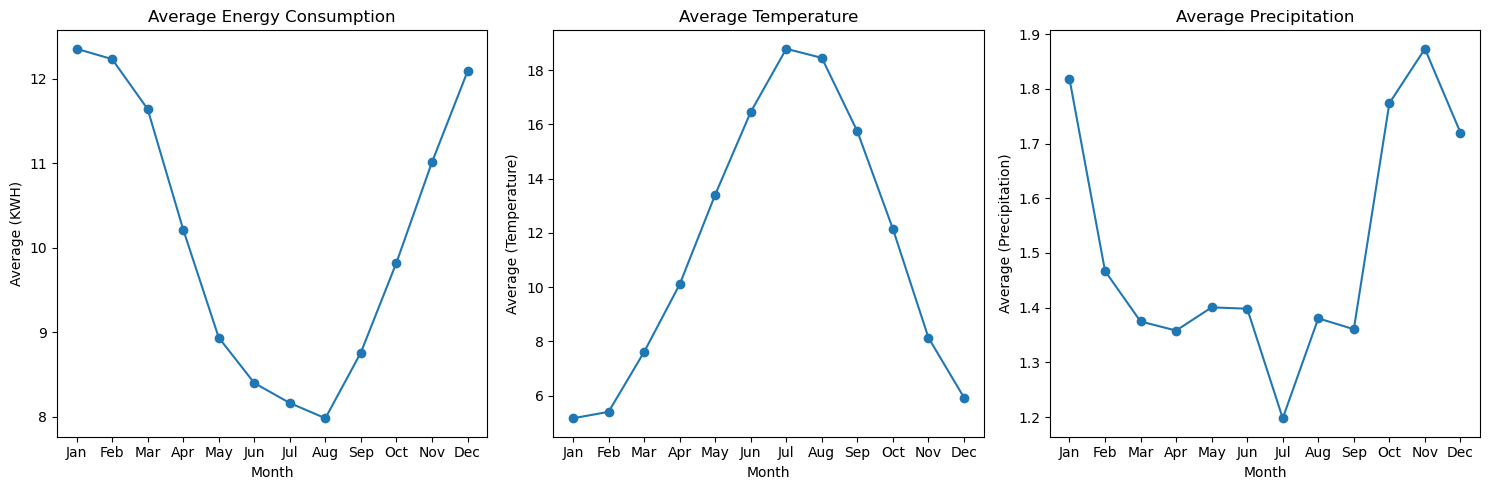

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

df_energy.rename(columns={'Date': 'date'}, inplace=True)
df_weather.rename(columns={'Date': 'date'}, inplace=True)

df_energy['date'] = pd.to_datetime(df_energy['date'])
df_weather['date'] = pd.to_datetime(df_weather['date'])

# Create a plot containing 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Energy
energy_monthly_mean = df_energy.groupby(df_energy['date'].dt.month)['KWH'].mean()
axes[0].plot(energy_monthly_mean.index, energy_monthly_mean.values, marker='o', linestyle='-')
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[0].set_title('Average Energy Consumption')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Average (KWH)')

# mean_temp
temp_monthly_mean = df_weather.groupby(df_weather['date'].dt.month)['mean_temp'].mean()
axes[1].plot(temp_monthly_mean.index, temp_monthly_mean.values, marker='o', linestyle='-')
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[1].set_title('Average Temperature')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average (Temperature)')

# precipitation
precipitation_monthly_mean = df_weather.groupby(df_weather['date'].dt.month)['precipitation'].mean()
axes[2].plot(precipitation_monthly_mean.index, precipitation_monthly_mean.values, marker='o', linestyle='-')
axes[2].set_xticks(range(1, 13))
axes[2].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[2].set_title('Average Precipitation')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Average (Precipitation)')


plt.tight_layout()
plt.show()


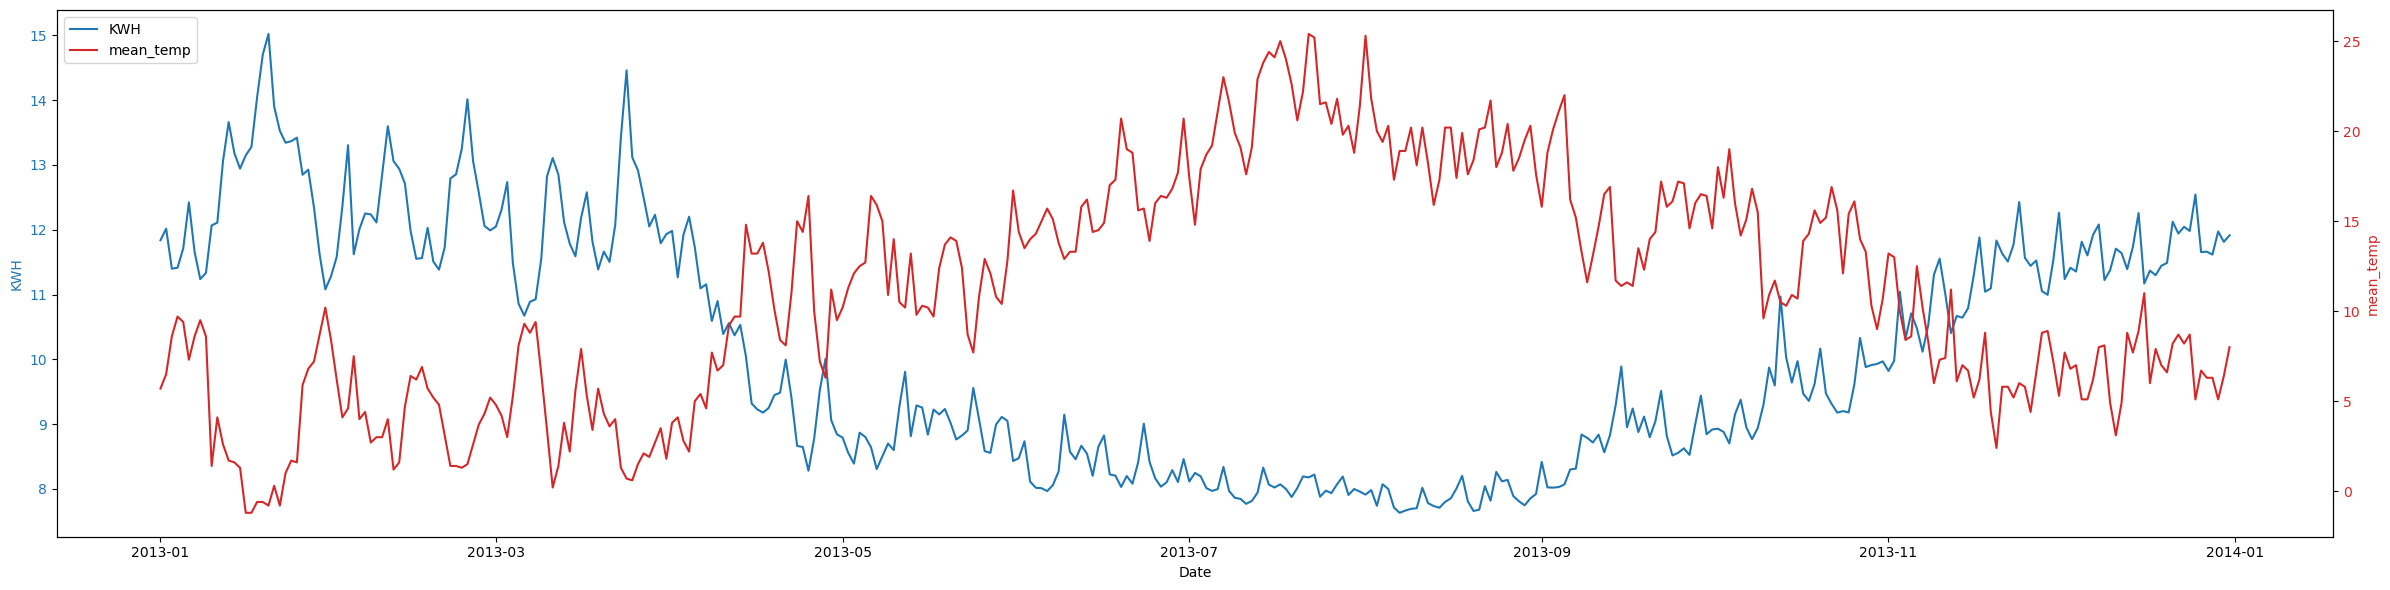

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the data in 2013
start_date = '2013-01-01'
end_date = '2013-12-31'
df_energy_2013 = df_energy[(df_energy['date'] >= start_date) & (df_energy['date'] <= end_date)]
df_weather_2013 = df_weather[(df_weather['date'] >= start_date) & (df_weather['date'] <= end_date)]

# Merge the two data frame
merged_df = pd.merge(df_energy_2013, df_weather_2013, on='date', how='inner')

# Create the plot
fig, ax1 = plt.subplots(figsize=(24, 6))

ax1.plot(merged_df['date'], merged_df['KWH'], color='tab:blue', label='KWH')
ax1.set_xlabel('Date')
ax1.set_ylabel('KWH', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create another y-axis
ax2 = ax1.twinx()
ax2.plot(merged_df['date'], merged_df['mean_temp'], color='tab:red', label='mean_temp')
ax2.set_ylabel('mean_temp', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# add the legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper left')

# show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [32]:
correlation_energy_temp = merged_df['KWH'].corr(merged_df['mean_temp'])
correlation_energy_precipitation = merged_df['KWH'].corr(merged_df['precipitation'])


In [33]:
correlation_energy_precipitation

0.14710441541878827

In [34]:
correlation_energy_temp

-0.9178605056118722

## Create a linear model using mean_temp to predict energy consumption

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

merged_df = pd.merge(df_energy_2013, df_weather_2013, on='date', how='inner')

# Extract the data
X = merged_df[['mean_temp']]
y = merged_df['KWH']

# Split the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the model
model_energy = LinearRegression()
model_energy.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = model_energy.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"MSE: {mse:.2f}")


MSE: 0.51


Visualize the model

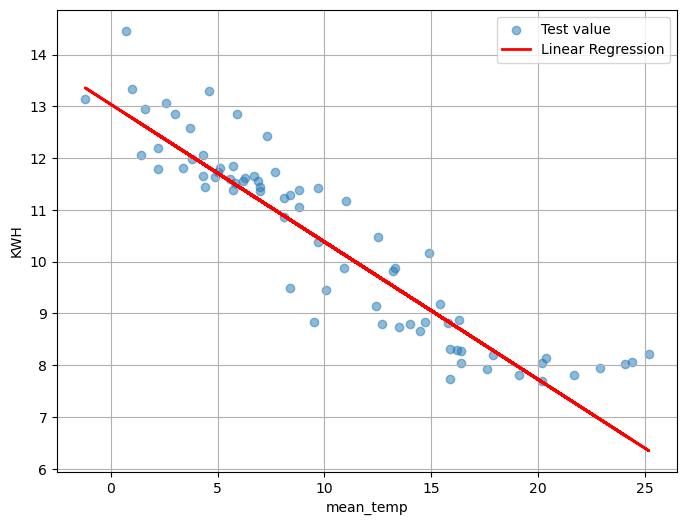

In [42]:
# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, alpha=0.5, label='Test value')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Linear Regression')
plt.xlabel('mean_temp')
plt.ylabel('KWH')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
intercept = model_energy.intercept_
slope = model_energy.coef_[0]

print(f"Intercept: {intercept:.2f}")
print(f"Slope: {slope:.2f}")

Intercept: 13.04
Slope: -0.27


## Predict mean_temp in 2013

Load the data

In [20]:
df=pd.read_csv('../dataset_for_analysis/data_weather_new1.csv',parse_dates=['date'])
df.set_index('date', inplace=True)

# Select the data used for model training
start_date='2013-01-01'
end_date='2013-12-31'
training_data=df[start_date:end_date]

X_mean_temp=training_data[['mean_temp','precipitation']]

Data processing

In [21]:
from sklearn.preprocessing import MinMaxScaler
scalar=MinMaxScaler(feature_range=(-1,1))
scaled_mean_temp=scalar.fit_transform(X_mean_temp[['mean_temp','precipitation']])

In [22]:
timestep=30
X=[]
Y=[]
for i in range(len(X_mean_temp)-timestep):
    X.append(scaled_mean_temp[i:i+timestep])
    Y.append(scaled_mean_temp[i+timestep])

In [26]:
X=np.asanyarray(X)
Y=np.asanyarray(Y)

Load the model

In [44]:
from tensorflow.keras.models import load_model
model=load_model('../lstm_results/lstm_mean_temp_and_precipitation.hdf5')

Make predictions

In [29]:
# Initiate the result array
predicted_result = np.zeros((335, 2))

# Iterate each day in 2020
for day_idx in range(335):

    input_data = X[day_idx, :, :]
    predictions = model.predict(input_data.reshape(1, 30, 2))[0]
    predicted_result[day_idx, :] = predictions


1/1 [==============================] - 0s 30ms/step


In [30]:
predicted_result=scalar.inverse_transform(predicted_result)
actual_ytest=scalar.inverse_transform(Y)

In [54]:
actual_ytest

array([[ 8.4,  5.8],
       [ 6.2,  0.6],
       [ 4.1,  0. ],
       [ 4.6,  0. ],
       [ 7.5,  3. ],
       [ 4. ,  1. ],
       [ 4.4,  0. ],
       [ 2.7,  0.2],
       [ 3. ,  0.2],
       [ 3. ,  2.4],
       [ 4. , 17.6],
       [ 1.2,  4.2],
       [ 1.6,  0.2],
       [ 4.7,  1.8],
       [ 6.4,  0. ],
       [ 6.2,  0. ],
       [ 6.9,  0.2],
       [ 5.7,  0. ],
       [ 5.2,  0.2],
       [ 4.8,  0.2],
       [ 3.1,  0.2],
       [ 1.4,  0. ],
       [ 1.4,  0. ],
       [ 1.3,  0. ],
       [ 1.5,  0. ],
       [ 2.6,  0.4],
       [ 3.7,  0.2],
       [ 4.3,  0. ],
       [ 5.2,  0.2],
       [ 4.8,  0.2],
       [ 4.2,  0. ],
       [ 3. ,  0. ],
       [ 5.3,  0. ],
       [ 8.1,  0. ],
       [ 9.3,  4.8],
       [ 8.8,  1.8],
       [ 9.4,  6.8],
       [ 6.5,  0.2],
       [ 3.4,  0. ],
       [ 0.2,  0. ],
       [ 1.4,  0. ],
       [ 3.8,  0. ],
       [ 2.2,  1.2],
       [ 5.6,  6.6],
       [ 7.9,  7.6],
       [ 5.3,  6.6],
       [ 3.4,  1.8],
       [ 5.7,

In [31]:
from sklearn.metrics import mean_squared_error
print(f'The MSE of mean_temp prediction: {mean_squared_error(predicted_result[:,0],actual_ytest[:,0]):.3f}')
print(f'The MSE of precipitation prediction: {mean_squared_error(predicted_result[:,1],actual_ytest[:,1]):.3f}')

The MSE of mean_temp prediction: 3.897
The MSE of precipitation prediction: 6.394


## Predict energy consumption using mean_temp obtained by the model

In [60]:
predicted_result.shape

(335, 2)

In [61]:
mean_temp=predicted_result[:,0].reshape(-1,1)
predicted_energy=model_energy.predict(mean_temp)

C:\Users\Thomas\.conda\envs\finalproject_new\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Calculate the mse

In [62]:
import pandas as pd
from sklearn.metrics import mean_squared_error

# Extract the data in 2013
start_date = '2013-01-31'
end_date = '2013-12-31'
df_energy_actual_values = merged_df[(merged_df['date'] >= start_date) & (merged_df['date'] <= end_date)]['KWH'].values

mse = mean_squared_error(df_energy_actual_values, predicted_energy)

print(f"MSE: {mse:.2f}")


MSE: 0.56


Visualize the result

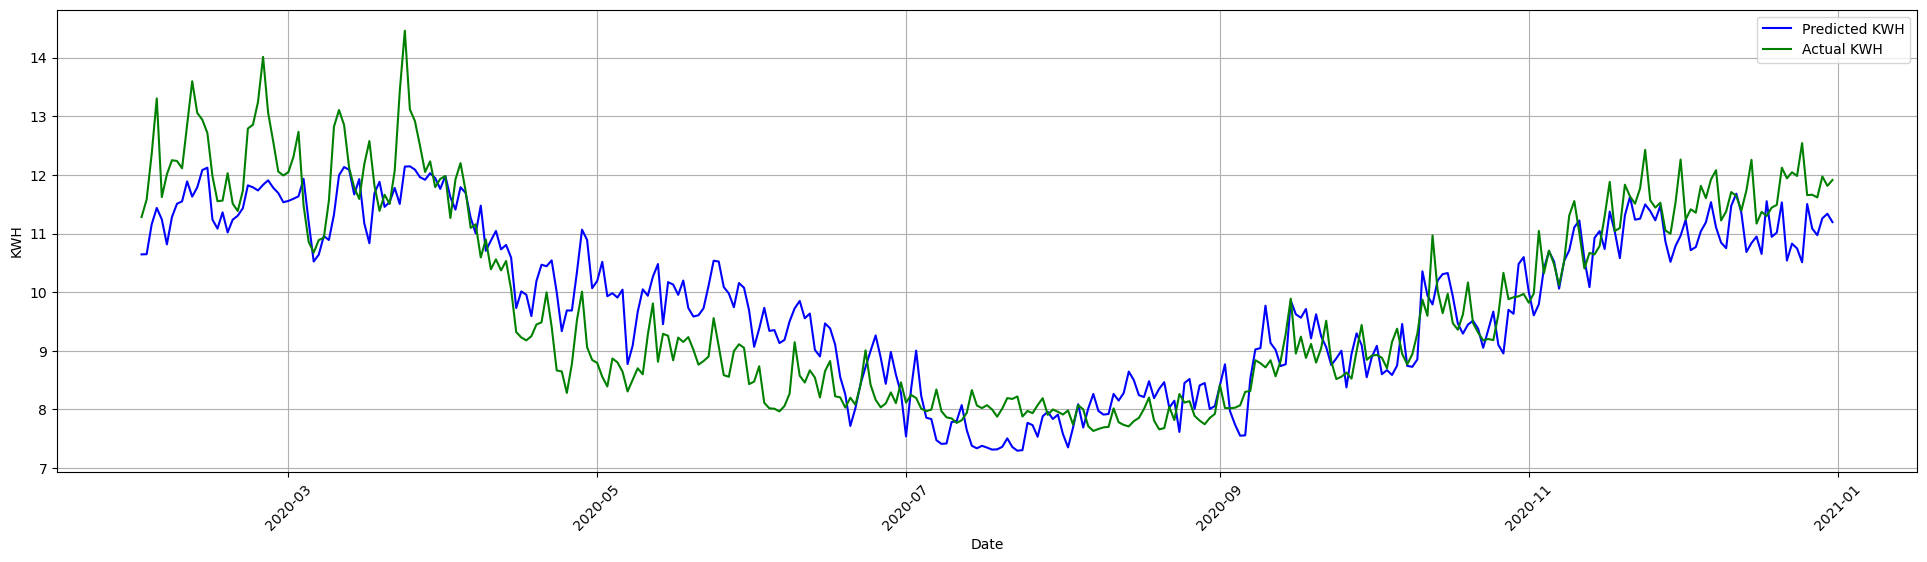

In [64]:
dates = pd.date_range(start='2020-02-01', end='2020-12-31')

# Create the plot
plt.figure(figsize=(24, 6))
plt.plot(dates, predicted_energy, label='Predicted KWH', color='blue')
plt.plot(dates, df_energy_actual_values, label='Actual KWH', color='green')
plt.xlabel('Date')
plt.ylabel('KWH')
plt.legend()
plt.grid(True)

plt.xticks(rotation=45)
plt.show()
